# <center>The simplex algorithm</center>
### <center>Alfred Galichon (NYU & Sciences Po)</center>
## <center>'math+econ+code' masterclass series</center>
#### <center>With python code examples</center>
© 2018–2023 by Alfred Galichon with contributions by Antoine Jacquet. Past and present support from NSF grant DMS-1716489, ERC grant CoG-866274 are acknowledged, as well as inputs from contributors listed [here](http://www.math-econ-code.org/team).

**If you reuse material from this masterclass, please cite as:**<br>
Alfred Galichon, 'math+econ+code' masterclass series. https://www.math-econ-code.org/

### Learning objectives

* Standard form of a LP and slack variables
* The simplex algorithm

### References

* Vanderbei (1996). *Linear programming.* Springer

# 1. Primal simplex via dictionary

The simplex algorithm was developed by G. B. Dantzig in 1947 as a way to solve linear programming problems of the canonical form

\begin{align}
\max_{x\in\mathbf R_+^J} & ~ c^\top x \\
\text{s.t.} & ~ Ax \leq d
\end{align}

where $c \in \mathbf R^J$, $d \in \mathbf R^I$, and $A$ is a $I\times J$ matrix. We assume that $I<J$, and that $A$ is of full rank, hence $rk(A) = I$.

The idea of the algorithm is to start from a simple feasible point called a *basic feasible solution*, and then to iteratively identify directions along which the objective function increases.

Let's begin by loading the usual packages.

In [1]:
#!pip install gurobipy
import pandas as pd
import numpy as np
import scipy.sparse as spr
import gurobipy as grb
import sympy
from sympy.solvers import solve
from sympy import *
import matplotlib.pyplot as plt
from mec.lp import LP,round_expr, limited_tabulate
from mec.data import load_stigler_data


## 1.1 An example

Consider the linear programming problem:

\begin{align*}
\max_{x_1, x_2 \geq 0}  & ~ x_1 + x_2 \\
\text{s.t.} & ~ 2 x_1 + x_2 \leq 2 \\
            & ~ x_1 + 2 x_2 \leq 2.
\end{align*}


Before even starting the algorithm, we first need to transform this linear program into one in *standard form*, that is, to replace inequality constraints with equality ones. To achieve this, we introduce slack variables $s_i$ to rewrite the problem as

\begin{align*}
\max_{x_1, x_2, s_1, s_2 \geq 0}  & ~ x_1 + x_2 \\
\text{s.t.} & ~ s_1 = 2 - 2 x_1 - x_2 \\
            & ~ s_2 = 2 - x_1 - 2 x_2 .
\end{align*}

The variables $s_i$ are called *slack variables*, and the variables $x_j$ are called *decision variables*.

Linear programming problems in this standard form can be summarized by a structure called a *dictionary*, which restates the constraints and the objective by expressing $I$ variables called *basic variables* as a function of the others called *nonbasic variables*. 

Given that in our example<br>
$s_1 = 2 - 2 x_1 - x_2$ and<br>
$s_2 = 2 - x_1 - 2 x_2 $,<br>
we see that initially, the slack basic variables are the basic ones, and the decision variables are the nonbasic ones, but this will change over time.


We shall call $K=I+J$ the total number of variables (slack or decision variables all together), and denote $z_k$ a generic variable (which concatenates slack and decision variable), so that $z^\top = (s^\top,x^\top)$. We denote $\{ z_b \}$ the set of basic variables, and $\{z_n\}$ the set of nonbasic variables.

We let $B$ be the matrix formed by the set of columns of $(\mathbf{I}_I~A)$ corresponding to basic variables and $N$ the matrix formed by set of the columns of the same matrix corresponding to the nonbasic variables, so that we have $B (x_b) + N (x_n) = d$, and thus the dictionary is given by<br>
$ (z_b) = (t_b) - T (z_n)$<br>
where $t=B^{-1} d$ and $T=B^{-1} N$,<br> 
and the objective is<br>
$Obj = (c_b)^\top B^{-1} d + ((c_n)^\top - (c_b)^\top B^{-1} N )z_n$.  



We begin by defining a `Dictionary` class in Python to handle this type of data.  The expressions of the objective and of the basic variables as a function of the nonbasic ones are encoded into a *dictionary*:

In [2]:
class Dictionary(LP):
    def __init__(self, A_i_j, d_i, c_j , slack_var_names_i=None,decision_var_names_j=None): # s_i = d_i - A_i_j @ x_j
        LP.__init__(self,A_i_j, d_i, c_j,decision_var_names_j,slack_var_names_i)
        self.nonbasic = symbols(self.decision_var_names_j)
        self.base = { Symbol('obj') : c_j @ self.nonbasic }
        slack_exprs_i = d_i  - A_i_j @ self.nonbasic
        self.base.update({Symbol(name): slack_exprs_i[i] for (i,name) in enumerate(self.slack_var_names_i) })

    def variables(self):
        return( list(self.base.keys())[1:] + self.nonbasic)

    def display(self):
        print('-------------------------- \nObjective and constraints:')
        for var in self.base:
            print(var, '=', round_expr(self.base[var],2))

We then define the dictionary corresponding to our example.

In [3]:
def build_simple_example():
    return ({'A_i_j': np.array([[2, 1], [1, 2]]),
            'd_i': np.array([2,2]),
            'c_j': np.array([1,1])
           })

dictionary_example = Dictionary(**build_simple_example(),
                                slack_var_names_i = ['s_1', 's_2'],
                                decision_var_names_j = ['x_1', 'x_2']
                                )

dictionary_example.display()

-------------------------- 
Objective and constraints:
obj = x_1 + x_2
s_1 = -2*x_1 - x_2 + 2
s_2 = -x_1 - 2*x_2 + 2


## 1.2 Description of the algorithm

Let's take a step-by-step approach to understand the simplex algorithm.
Along the way, we will also code these steps.

#### **Step 1: Initialize.**
Our first step is to establish a (feasible) starting point. There is an obvious one which consists in setting $x_1 = x_2 = 0$ and $s_1 = 2$, $s_2 = 2$. This starting point is called a *basic feasible solution* because it is zero outside of the basic variables. The value of the objective at this solution is $0$.

We create a method which computes the basic feasible solution associated with a dictionary, as well as the value of the objective at this solution.

In [4]:
def Dictionary_primal_solution(self, verbose=0):
    x_j = np.zeros(self.nbj)
    for j,var in enumerate(symbols(self.decision_var_names_j)):
        x_j[j]=float( self.base.get(var,sympy.Integer(0)).subs([(variable,0) for variable in self.nonbasic]) )
        if verbose > 0:
            print(var, '=', x_j[j])
    return x_j

Dictionary.primal_solution = Dictionary_primal_solution

We plot the feasible region and our initial solution using:


x_1 = 0.0
x_2 = 0.0


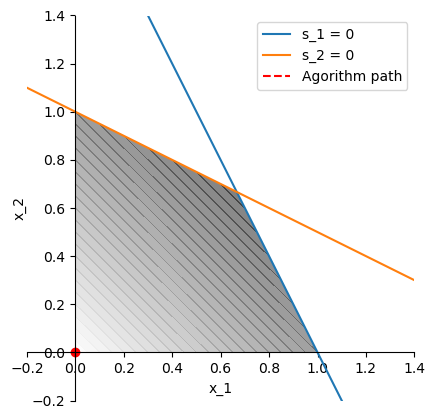

In [5]:
path_example = [dictionary_example.primal_solution(verbose=1)]
dictionary_example.plot2d(path_example)

#### **Step 2: Entering variable.**
We want to grow a nonbasic variable in order to increase our objective. This variable is called *entering variable*. This growth will be offset by an adjustment in the basic variables. Any nonbasic variable whose coefficient in the objective is positive is therefore a potential entering variable.

There are several ways to choose the entering variable. One possibility is to choose the variable that has the highest coefficient in the objective.

Another method is to follow *Bland's rule*, i.e. to select the first variable (in the alphabetical order) which has a positive coefficient in the objective. This method is the safest as it prevents the algorithm from cycling in some pathological cases, and therefore we will implement it here.

Recall that the objective in our example is $x_1 + x_2$, and therefore Bland's rule selects $x_1$ as the entering variable.

In [6]:
def Dictionary_determine_entering(self):
    self.nonbasic.sort(key=str) # Bland's rule
    for entering_var in self.nonbasic:
        if diff(self.base[Symbol('obj')],entering_var) > 0 :
            return entering_var
    return None # If no entering variable found, None returned

Dictionary.determine_entering = Dictionary_determine_entering

entering_var = dictionary_example.determine_entering()
entering_var

x_1

#### **Step 3: Departing variable.**
Recall, the increase in the nonbasic variable $x_1$ needs to be offset by an adjustment in the basic variables. Here, the basic variables are the slack variables $s_i$. More precisely, if we set $x_1>0$, we need to adjust $s_i$ by $- A_{i1} x_1$. If $A_{i1}\leq 0$, this does not threaten the feasibility constraint $s_i \geq 0$, but if $A_{i1}>0$, it does. Hence we shall increase the value of $x_1$ until we hit any of the constraints $s_i \geq 0$. Recall:

\begin{align*}
s_1 &= 2 - 2 x_1 - x_2 \\
s_2 &= 2 - x_1 - 2 x_2.
\end{align*}

Note that we keep $x_2=0$ along the way. Here it is the constraint $s_1 \geq 0$ which will hit first (for $x_1 = 1$). Therefore we choose $s_1$ as our *departing variable*.

In general, if $n^\star$ is the entering variable, the formula for determining the departing variable is

$b^\star = \arg\min_{b} \left\{ \frac {t_b} {T_{b \, n^\star}} : T_{b \, n^\star} > 0  \right\}$.

We code this into:

In [7]:
def Dictionary_determine_departing(self,entering_var):
    runmin = float('inf')
    departing_var = None
    for var in self.base.keys() - {Symbol('obj')}:
        the_expr_list = solve(self.base[var] - var,entering_var)
        if the_expr_list: # if one can invert the previous expression
            the_expr = the_expr_list[0] # express entering variable as a function of the other ones:
            val_entering_var = the_expr.subs([ (variable,0) for variable in [var]+self.nonbasic])
            if (val_entering_var >= 0) & (val_entering_var < runmin) :
                runmin,departing_var = val_entering_var, var
    return departing_var # if no variable is found, None returned

Dictionary.determine_departing = Dictionary_determine_departing

departing_var = dictionary_example.determine_departing(entering_var)
departing_var

s_1

#### **Step 4: Updating.**
We reformulate our problem with our new basis $(x_1, s_2)$. We use the constraint associated with our departing variable $s_1$ as a pivot to eliminate the entering variable $x_1$ from the other equalities:

\begin{matrix}
&\tfrac{1}{2}s_1  &       &~+ x_1 &+~ \tfrac{1}{2} x_2 &= 1 \\
&-\tfrac{1}{2}s_1 &+~ s_2 &       &+~ \tfrac{3}{2} x_2 &= 1
\end{matrix}

and we rewrite the objective as a function of the new nonbasic variables:

\begin{align*}
x_1 + x_2
&= \left(1 - \tfrac{1}{2}s_1 - \tfrac{1}{2}x_2\right) + x_2 \\
&= 1 + \tfrac{1}{2}x_2 - \tfrac{1}{2}s_1.
\end{align*}

In general, once the entering variable $n^\star$ and the departing variable $b^\star$ have been determined, we need to update our set of nonbasic variables by removing $b^\star$ from it and adding $n^\star$. We also need to update our dictionary with the expression of our entering variable,

$z_{n^\star}
= \frac {t_{b^\star}} {T_{b^\star n^\star}}
- \sum_{n \neq n^\star} \frac {T_{b^\star n}} {T_{b^\star n^\star}} z_n
- \frac {z_{b^\star}} {T_{b^\star n^\star}}$

and substituting out this expression in

$z_b = t_b - \sum_n T_{bn} z_n, \quad b \neq b^\star$

yields the expression of the new basic variables as a function of the new nonbasic variables.

In [8]:
def Dictionary_pivot(self,entering_var,departing_var, verbose = 0):
    expr_entering = solve(self.base[departing_var] - departing_var,entering_var)[0]
    for var in self.base:
        self.base[var] = self.base[var].subs([(entering_var, expr_entering)])
    self.base[entering_var] = expr_entering
    del self.base[departing_var]
    self.nonbasic.remove(entering_var)
    self.nonbasic.append(departing_var)
    if verbose > 0:
        print('Entering = ' + str( entering_var)+'; departing = '+ str( departing_var))
    if verbose > 1:
        print(str( entering_var)+' = '+str(round_expr(expr_entering,2)))
    return expr_entering

Dictionary.pivot = Dictionary_pivot

expr_entering_var = dictionary_example.pivot(entering_var,departing_var,verbose = 2)

dictionary_example.display()

Entering = x_1; departing = s_1
x_1 = -0.5*s_1 - 0.5*x_2 + 1
-------------------------- 
Objective and constraints:
obj = -0.5*s_1 + 0.5*x_2 + 1
s_2 = 0.5*s_1 - 1.5*x_2 + 1
x_1 = -0.5*s_1 - 0.5*x_2 + 1


This completes one iteration of the algorithm.

### Iterating

The transformed program is now:

\begin{align*}
\max_{x_1, x_2, s_1, s_2 \geq 0}  & ~ 1 + \tfrac{1}{2}x_2 - \tfrac{1}{2}s_1 \\
\text{s.t.} & ~ x_1 = 1 - \tfrac{1}{2} x_2 - \tfrac{1}{2} s_1 \\
            & ~ s_2 = 1 - \tfrac{3}{2} x_2 + \tfrac{1}{2}s_1 .
\end{align*}

Our new basic feasible solution is $x_2 = s_1 = 0$ (nonbasic variables) and $x_1 = 1$, $s_2 = 1$ (basic variables). The value of the objective is $1$.



Let's look at the path that the algorithm took using the graph.

x_1 = 1.0
x_2 = 0.0


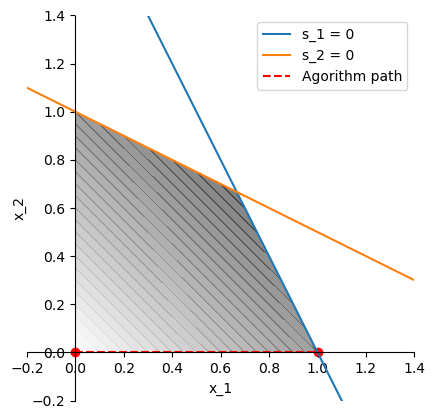

In [9]:
currentx_j = dictionary_example.primal_solution(verbose=2)
path_example.append(currentx_j)
dictionary_example.plot2d(path_example)

We can now repeat the process on the new program. Since the coefficient of $x_2$ in our new objective is positive, we now choose $x_2$ as an entering variable. In that case, the constraint associated with the basic variable $s_2$ will hit first, so $s_2$ will be our departing variable.

The pivot operation yields

\begin{matrix}
&\tfrac{2}{3}s_1  &-~ \tfrac{1}{3} s_2       &~+ x_1 & &= \tfrac{2}{3} \\
&-\tfrac{1}{3}s_1 &+~ \tfrac{2}{3} s_2 &       &+~ x_2 &= \tfrac{2}{3}
\end{matrix}

and the new objective is

\begin{align*}
1 + \tfrac{1}{2}x_2 - \tfrac{1}{2}s_1
&= 1 + \tfrac{1}{2}\left(\tfrac{2}{3} + \tfrac{1}{3}s_1 - \tfrac{2}{3}s_2\right) - \tfrac{1}{2}s_1 \\
&= \tfrac{4}{3} - \tfrac{1}{3}s_1 - \tfrac{1}{3}s_2.
\end{align*}

We encode this second iteration as:

In [10]:
def Dictionary_step(self,verbose=0):
    entering_var = self.determine_entering()
    if entering_var is None:
        print('Optimal solution found.\n=======================')
        self.primal_solution(verbose)
    else:
        departing_var = self.determine_departing(entering_var)
        if departing_var is None:
            print('Unbounded solution.')
        else:
            expr_entering_var = self.pivot(entering_var,departing_var, verbose)
            return False # not finished
    return True # finished

Dictionary.step = Dictionary_step

Entering = x_2; departing = s_2
x_2 = 0.33*s_1 - 0.67*s_2 + 0.67
x_1 = 0.6666666666666666
x_2 = 0.6666666666666666


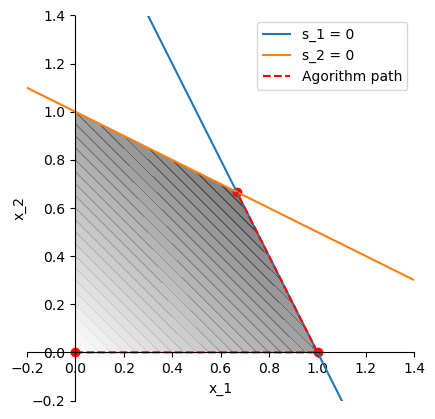

In [11]:
dictionary_example.step( verbose=2)

path_example.append( dictionary_example.primal_solution(verbose=1) )
dictionary_example.plot2d(path_example)

Our new basic feasible solution is $s_1 = s_2 = 0$ (nonbasic variables) and $x_1 = \tfrac{2}{3}$, $x_2 = \tfrac{2}{3}$ (basic variables). But because the coefficients of the nonbasic variables in the objective are negative, we cannot increase it anymore: the algorithm stops.

### Geometric interpretation

The simplex algorithm has a simple geometric interpretation.

The feasible set of the linear programming problem, delimited by its constraints, forms a polygon in $\mathbb R^2$ (a polyhedron in $\mathbb R^3$, etc.).

We start from one of the corners of this polygon. At each iteration of the algorithm, we move along the edge of the polygon to a neighboring corner, always moving in the direction that most increases the value of the objective function. When it reaches the corner with the highest possible value of the objective function, the algorithm stops, and we have our solution.

The simplex algorithm must stop eventually since there is a finite limited number of corners. Furthermore, it can be shown that if a corner isn't a maximum, then there must be an adjoining edge leading to a higher value of the objective function. This guarantees that the end point of the algorithm is indeed an optimal solution.

We verify this with our code that there is no entering variable anymore.

In [12]:
print('Entering =',dictionary_example.determine_entering())
dictionary_example.primal_solution()

Entering = None


array([0.66666667, 0.66666667])

The value of the initial problem is thus $\tfrac{4}{3}$, and the optimal solution is

\begin{equation}
  x_1^* = x_2^* = \tfrac{2}{3}.
\end{equation}

# 2. Dual simplex

The dual program is


\begin{align}
\min_{(y_j) \geq 0} & d^\top y  \\
\text{s.t.} & ~ A ^\top y \geq c
\end{align}

and we introduce dual slack variables

$t_j = (A^\top y)_j - c_j$

After adding the slack variables, the constraint matrix becomes $[A^\top ~ I]$. This is a $J \times (I+J)$ matrix, which has $J$ free columns, and thus it is of rank $J$. Therefore a dual basis will be of cardinality $J$ -- in contrast with the primal basis, which is of cardinality $I$.


## 2.1 Dual dictionary
An initial dual basis is provided by the dual slack variables $t_j$. We note that at step zero, the dual basis $(t_j)$ is in an a one-to-one correspondence with the complement of the primal basis, which is $(s_i)$. Indeed, we associate an nonbasic primal variable $x_j$ to each basic dual variable $t_j$, and a basic primal variable $t_i$ to each nonbasic dual variable $y_i$.

In [13]:
A_i_j,d_i,c_j = build_simple_example().values()

primal_dictionary = Dictionary(A_i_j,d_i,c_j ,
                                slack_var_names_i = ['s_1', 's_2'],
                                decision_var_names_j = ['x_1', 'x_2']
                                )

dual_dictionary = Dictionary(A_i_j.T,c_j ,d_i,
                                slack_var_names_i = ['t_1', 't_2'],
                                decision_var_names_j = ['y_1', 'y_2']
                                )
corresp = {Symbol(primalvar):Symbol(dualvar) 
           for (primalvar,dualvar) in zip(primal_dictionary.slack_var_names_i+primal_dictionary.decision_var_names_j,
                                         dual_dictionary.decision_var_names_j+dual_dictionary.slack_var_names_i)}

print(corresp)

{s_1: y_1, s_2: y_2, x_1: t_1, x_2: t_2}



We will therefore re-run the simplex algorithm, but we will update the dual dictionary in addition to the primal dictionary. If a primal variable enters the primal basis, the corresponding dual variable will exit the dual basis, and conversely. 

In [14]:
finished = False
while not finished:    
    entering_var = primal_dictionary.determine_entering()
    if entering_var is None:
        print('Optimal solution found.\n=======================')
        primal_dictionary.primal_solution(verbose=1)
        dual_dictionary.primal_solution(verbose=1)
        finished = True
    else:
        departing_var = primal_dictionary.determine_departing(entering_var)
        primal_dictionary.pivot(entering_var,departing_var, verbose=1)
        dual_dictionary.pivot(corresp[departing_var],corresp[entering_var], verbose=1)

primal_dictionary.display()
dual_dictionary.display()

Entering = x_1; departing = s_1
Entering = y_1; departing = t_1
Entering = x_2; departing = s_2
Entering = y_2; departing = t_2
Optimal solution found.
x_1 = 0.6666666666666666
x_2 = 0.6666666666666666
y_1 = 0.3333333333333333
y_2 = 0.3333333333333333
-------------------------- 
Objective and constraints:
obj = -0.33*s_1 - 0.33*s_2 + 1.33
x_1 = -0.67*s_1 + 0.33*s_2 + 0.67
x_2 = 0.33*s_1 - 0.67*s_2 + 0.67
-------------------------- 
Objective and constraints:
obj = -0.67*t_1 - 0.67*t_2 + 1.33
y_1 = -0.67*t_1 + 0.33*t_2 + 0.33
y_2 = 0.33*t_1 - 0.67*t_2 + 0.33


## 2.2 Recovering the dual solution from the primal dictionary

In fact, we can recover the dual solution directly from the primal dictionary. Recall that the objective is<br>
$Obj = (c_b)^\top B^{-1} d + ((c_n)^\top - y^\top N )z_n$<br>
where $y^\top = (c_b)^\top B^{-1}$.

Therefore, we have:<br>
$\frac {\partial Obj} {\partial z_n} = c_n - (N^\top y)_n$<br>
but if $z_n$ is the slack variable $s_i$, we have $c_n=0$, and $N_{i^\prime n} = 1\{i = i^\prime \} $, and thus<br>
$\frac {\partial Obj} {\partial z_n} = -y_i$.

In [15]:
def Dictionary_dual_solution(self,verbose = 0):
    y_i = np.zeros(self.nbi)
    for i,slackvar in enumerate(self.slack_var_names_i):
        y_i[i] = - diff(self.base[Symbol('obj')],slackvar)
        if verbose > 0 and y_i[i] != 0:
            print('pi_'+str(i)+'=', y_i[i])
    return y_i

Dictionary.dual_solution = Dictionary_dual_solution

dictionary_example.dual_solution(verbose=1)

pi_0= 0.3333333333333333
pi_1= 0.3333333333333333


array([0.33333333, 0.33333333])

# 3. Complements

## 3.1 A more complex example

Consider a slightly more complex example:

\begin{align*}
\max_{x_1, x_2 \geq 0}  & ~ 3 x_1 + 2 x_2 \\
\text{s.t.} & ~ \cos\left(\tfrac{k}{K}\tfrac{\pi}{2}\right) x_1 + \sin\left(\tfrac{k}{K}\tfrac{\pi}{2}\right) x_2 \leq 1, \quad k = 0, \dots, K.
\end{align*}

The constraints actually correspond to $K+1$ tangents to the circle of equation $x_1^2 + x_2^2 = 1$. Therefore, it is as if we were approximating the nonlinear constraint $x_1^2 + x_2^2 \leq 1$.

We code a complete iteration of the simplex algorithm with `Dictionary_loop`, and finally we code the complete simplex algorithm by repeating this loop until there is no entering variable anymore.

In [16]:
def Dictionary_simplex_loop(self,verbose = 0):
    if verbose >2:
        [x1,x2] = symbols(self.decision_var_names_j)
        the_path = [self.primal_solution()]
    finished = False
    while not finished:
        finished = self.step()
        if verbose>2:
            the_path.append(self.primal_solution())
    objVal = self.base[Symbol('obj')].subs([ (variable,0) for variable in self.nonbasic])
    if verbose>0:
        print('\nValue = ' + str(objVal))
    if verbose >2:
        self.plot2d(the_path, legend=False)
    return (self.primal_solution(),self.dual_solution(),objVal)
    

Dictionary.simplex_loop = Dictionary_simplex_loop

Optimal solution found.

Value = 3.61405855890019


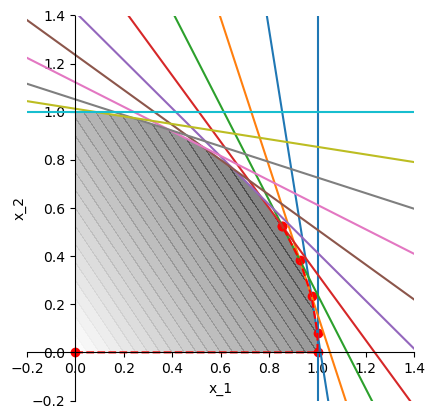

(array([0.8552767 , 0.52411423]),
 array([0.        , 0.        , 0.        , 0.9289626 , 2.68509595,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]),
 3.61405855890019)

In [17]:
T = 10

dictionary_example2 = Dictionary(A_i_j = np.array([(float(cos(t/T*pi/2)), float(sin(t/T*pi/2))) for t in range(0, T+1)]),
                                 d_i = np.ones(T+1),
                                 c_j = np.array([3,2]),
                                 slack_var_names_i = ['s_'+str(t) for t in range(0,T+1)],
                                 decision_var_names_j = ['x_1', 'x_2'])

dictionary_example2.simplex_loop(verbose=3)


In [18]:
dictionary_example2.primal_solution()

array([0.8552767 , 0.52411423])

Our algorithm still works -- however we see that it becomes quite slow for higher values of $K$ -- not surprising, given that it had to visit a large number of intermediate vertices before reaching the solution.


## 3.2 Application to the diet problem

Recall the diet problem:

* Assume there are nutrients $i \in \{1,\dots,I\}$ (calories, protein, calcium, iron, etc.) that matter for a person's health, in such way that the minimum daily intake of nutrient $i$ should be $d_{i}$.

* Nutrients do not come as standalone elements, but are combined into various foods. One dollar worth of food $j \in \{1,\dots,J\}$ yields a quantity $N_{ij}$ of nutrient $i \in \{1,\dots,I\}$.

The problem is to find the diet that achieves the minimal intake of each nutrient for the cheapest price. If $q\in\mathbb{R}^{J}$ is a vector such that $q_{j}\geq0$ is the quantity of food $j$ purchased, the quantity of nutrient $i$ ingested is $\sum_{j=1}^{J}N_{ij}q_{j}$, and the cost of the diet is $\sum_{j=1}^{J}q_{j}$. Letting $c_j = 1$ for all $j \in \{1,\dots,n\}$, the optimal diet is therefore given by

\begin{align*}
\min_{q\geq 0} & ~ c^{\top}q \\
\text{s.t.} & ~ Nq \geq d
\end{align*}

which has dual

\begin{align*}
\max_{\pi\geq0} & ~ d^{\top}\pi \\
\text{s.t.} & ~ N^{\top}\pi \leq c.
\end{align*}

We load the data using:

In [19]:
[N_i_j,minallowance_i,unitcost_j,_,_] = load_stigler_data(7,5).values()

We code this up as a `Dictionary`object. First, we define the basic dual variables (the $s_j$), and the nonbasic dual variables (the $\pi_i$) .

In [20]:
stigler_dictionary = Dictionary(N_i_j.T, unitcost_j , minallowance_i,
                             ['s_' + str(j) for j in range(N_i_j.shape[1])],
                             ['π_' + str(i) for i in range(N_i_j.shape[0])])
stigler_dictionary.simplex_loop(verbose=2)[1]

Optimal solution found.

Value = 0.227818067377138


array([0.03431968, 0.        , 0.03168609, 0.        , 0.1618123 ])

### Benchmark with Gurobi

We benchmark our solution with the one obtained by `Gurobi`, and verify that it is the same:

In [21]:
stigler_dictionary.gurobi_solve()[1]

Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-23


array([0.03431968, 0.        , 0.03168609, 0.        , 0.1618123 ])

Gurobi finds the same solution as our simplex algorithm coding — although significantly faster.

# 4. Alternative implementation via tableaux


Our implementation so far of the simplex algorithm provides a quick and intuitive version of the simplex, but the fact that it relies on `sympy` makes it extremely slow. In the sequel, we shall see a different implementation of the same algorithm using *tableaux*. 


The program in standard form is thus

\begin{align*}
\max_{z \geq 0}  & ~ (0^\top_I, c^\top) z \\
\text{s.t.}~& ~ (\mathbf{I_I}~A )~z = d.
\end{align*}

At each point in the algorithm, we denote $\{z_b\}$ the set of basic variables, and $\{z_n \}$ the set of nonbasic variables, and we have<br>
$B (z_b) + N (z_n) = d$


A tableau is a representation of the dictionary<br>
$ (z_b) = B^{-1} d - B^{-1} N (z_n)$<br>
under the form<br>
$T z  = B^{-1} d$.
Therefore, each row of the tableau will be associated with one basic variable $b\in B$; each column before the last of the tableau will be associated with a variable (basic or nonbasic).

Each row is associated with a basic variable $b$, the entry in the column associated with that basic variable is one; the column entries associated with the other basic variables are zero; and the column entries assocaited with nonbasic variables $n$ are equal with $(B^{-1} N)_{bn}$. 

The tableau also stores the objective in a similar fashion<br>
$Obj = (c_b)^\top( B^{-1} d )+ (c_n^\top -  B^{-1} N) (z_n)  $

For practical purposes, we will append a first row of the tableau where we store the expression of the objective, and add a last column where we store the right hand side $ B^{-1} d$.  

In [22]:
#from tabulate import tabulate

class Tableau(LP):
    def __init__(self, A_i_j, d_i, c_j,slack_var_names_i=None, decision_var_names_j = None): # s_i = d_i - (A_i_j @ x_j
        LP.__init__(self,A_i_j, d_i, c_j,decision_var_names_j,slack_var_names_i)
        self.nbi,self.nbj = A_i_j.shape
        self.nbk = self.nbi+self.nbj
        self.names_all_variables =  self.slack_var_names_i + self.decision_var_names_j
        self.tableau = np.block([[np.zeros((1,self.nbi)), c_j.reshape((1,-1)), 0],[np.eye(self.nbi),A_i_j,d_i.reshape((-1,1))]])
        self.k_b = list(range(self.nbi)) # columns associated with basic variables
        self.i_b = list(range(1,1+self.nbi)) # rows associated with basic variables

    def display(self):
        tableau = []
        tableau.append(['Obj'] + list(self.tableau[0,:])  )
        for b in range(self.nbi):
             tableau.append([self.names_all_variables[self.k_b[b]]]+list(self.tableau[self.i_b[b],:]) )
        
        print(limited_tabulate(tableau, headers=[''] + self.names_all_variables + ['RHS'], tablefmt="grid"))
        

    def determine_entering(self):
        for k in range(self.nbk):
            if self.tableau[0,k] > 0:
                return k
        return None # If no entering variable found, None returned

    def determine_departing(self,kent):
        thedic = {b: self.tableau[self.i_b[b],-1] / self.tableau[self.i_b[b],kent] 
                  for b in range(self.nbi) if self.tableau[self.i_b[b],kent]>0}
        bdep = min(thedic, key = thedic.get)
        return bdep

    def update(self,kent,bdep):
        idep = self.i_b[bdep]
        self.tableau[idep,:] = self.tableau[idep,:] / self.tableau[idep,kent] 
        for i in range(1+self.nbi):
            if i != idep:
                self.tableau[i,:]= self.tableau[i,:] - self.tableau[idep,:] * self.tableau[i,kent] 
                
        self.k_b[bdep] = kent
        self.i_b[bdep] = idep
        
    def simplex_step(self,verbose=0):
        if verbose>1:
            self.display()
        kent = self.determine_entering()
        if kent is not None:
            bdep= self.determine_departing(kent)
            name_entering = self.names_all_variables[kent]
            name_departing = self.names_all_variables[self.i_b[bdep]]
            if verbose>0:
                print('Entering=', name_entering, 'Departing=',name_departing,'Pivot=',(self.i_b[bdep],kent))
            self.update(kent,bdep)
        else:
            if verbose>0:
                print ('Optimal solution found.')
            if verbose>1:
                self.display()
        return (kent is not None) # returns false  if optimal solution; true otherwise

    def simplex_solve(self,verbose=0):
        while self.simplex_step(verbose):
            pass
        return self.solution()
        

    def solution(self):
        x_j = np.zeros(self.nbj)
        s_i = np.zeros(self.nbi)
        for b in range(self.nbi):
            if self.k_b[b]<self.nbi:
                s_i[self.k_b[b]] = self.tableau[self.i_b[b],-1]
            else:
                x_j[self.k_b[b]-self.nbi] = self.tableau[self.i_b[b],-1]
        y_i = - self.tableau[0,:self.nbi] 
        return(x_j,y_i,x_j@self.c_j)
    


In [23]:
tableau_ex = Tableau(np.array([[3, 1], [1, 3], [5,5]]),np.array([2,2,4]),np.array([1,3]))
tableau_ex.simplex_solve(verbose = 2)

+-----+-------+-------+-------+-------+-------+-------+
|     |   s_0 |   s_1 |   s_2 |   x_0 |   x_1 |   RHS |
+=====+=======+=======+=======+=======+=======+=======+
| Obj |     0 |     0 |     0 |     1 |     3 |     0 |
+-----+-------+-------+-------+-------+-------+-------+
| s_0 |     1 |     0 |     0 |     3 |     1 |     2 |
+-----+-------+-------+-------+-------+-------+-------+
| s_1 |     0 |     1 |     0 |     1 |     3 |     2 |
+-----+-------+-------+-------+-------+-------+-------+
| s_2 |     0 |     0 |     1 |     5 |     5 |     4 |
+-----+-------+-------+-------+-------+-------+-------+
Entering= x_0 Departing= s_1 Pivot= (1, 3)
+-----+-----------+-------+-------+-------+----------+-----------+
|     |       s_0 |   s_1 |   s_2 |   x_0 |      x_1 |       RHS |
+=====+===========+=======+=======+=======+==========+===========+
| Obj | -0.333333 |     0 |     0 |     0 | 2.66667  | -0.666667 |
+-----+-----------+-------+-------+-------+----------+-----------+
| x_0 

(array([0.2, 0.6]), array([-0.,  1., -0.]), 2.0)

Compare with Gurobi:

In [24]:
tableau_ex.gurobi_solve()

(array([0.        , 0.66666667]), array([0., 1., 0.]), 2.0)

## Another example

In [25]:
other_ex = Tableau(np.array([[1, 1], [2, 1]]),np.array([4,6]),np.array([3,2]))
other_ex.simplex_solve(verbose=2)

+-----+-------+-------+-------+-------+-------+
|     |   s_0 |   s_1 |   x_0 |   x_1 |   RHS |
+=====+=======+=======+=======+=======+=======+
| Obj |     0 |     0 |     3 |     2 |     0 |
+-----+-------+-------+-------+-------+-------+
| s_0 |     1 |     0 |     1 |     1 |     4 |
+-----+-------+-------+-------+-------+-------+
| s_1 |     0 |     1 |     2 |     1 |     6 |
+-----+-------+-------+-------+-------+-------+
Entering= x_0 Departing= x_0 Pivot= (2, 2)
+-----+-------+-------+-------+-------+-------+
|     |   s_0 |   s_1 |   x_0 |   x_1 |   RHS |
+=====+=======+=======+=======+=======+=======+
| Obj |     0 |  -1.5 |     0 |   0.5 |    -9 |
+-----+-------+-------+-------+-------+-------+
| s_0 |     1 |  -0.5 |     0 |   0.5 |     1 |
+-----+-------+-------+-------+-------+-------+
| x_0 |     0 |   0.5 |     1 |   0.5 |     3 |
+-----+-------+-------+-------+-------+-------+
Entering= x_1 Departing= s_1 Pivot= (1, 3)
+-----+-------+-------+-------+-------+-------+
| 

(array([2., 2.]), array([1., 1.]), 10.0)

In [26]:
other_ex.gurobi_solve()

(array([2., 2.]), array([1., 1.]), 10.0)

## Back to the diet problem

If we go back to the Stigler diet problem, we can appreciate how much faster we are.

In [27]:
stigler_tableau = Tableau(N_i_j.T, unitcost_j , minallowance_i,
                             ['s_' + str(j) for j in range(N_i_j.shape[1])],
                             ['π_' + str(i) for i in range(N_i_j.shape[0])])

stigler_tableau.simplex_solve()[1]

array([ 0.03431968, -0.        ,  0.03168609, -0.        ,  0.1618123 ])

In [28]:
stigler_tableau.gurobi_solve()[1]

array([0.03431968, 0.        , 0.03168609, 0.        , 0.1618123 ])